<a href="https://colab.research.google.com/github/oserikov/data-science-nlp/blob/master/1_%D1%87%D0%B0%D1%81%D1%82%D0%BE%D1%82%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip -qq install yargy --progress-bar off
!pip -qq install pymorphy2 --progress-bar off
!pip -qq install rusenttokenize --progress-bar off
import nltk
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)

!wget -q http://rusvectores.org/news_history/lenta_2018.txt.gz
    
!gunzip lenta_2018.txt.gz


LENTA_TEXTS_FN = "lenta_2018_texts.txt"
LENTA_TITLES_FH = "lenta_2018_titles.txt"

!cat lenta_2018.txt |\
 python3 -c "import sys; \
             [print(line.strip()) for idx, line in enumerate(sys.stdin) if idx%2==1]" \
 > {LENTA_TEXTS_FN}

!cat lenta_2018.txt |\
 python3 -c "import sys; \
             [print(line.strip()) for idx, line in enumerate(sys.stdin) if idx%2==0]" \
 > {LENTA_TITLES_FN}


gzip: lenta_2018.txt already exists; do you wish to overwrite (y or n)? т
	not overwritten


# Частотный анализ

Многие компьтерные методы анализа текста основаны на статистике — в нашем случае это частотность символов / словоформ / лексем / биграмм / триграмм / частей речи и т.д., ее отношение к длине текста, средняя длина текстов и т.д.

Зачем нам знать частотность слов в тексте? Например, она говорит о том, какие слова наиболее характеры для того или иного текста. Сравнивая частотные слова в разных текстах можно определить степень их близости, классифицировать по жанру, теме и т.п., а также выявить явления, характерные для языка в целом. 

Подход, когда текст представляется просто как куча слов, без информации об их порядке, называется **bag of words**.

**Частотный словарь русского языка**, составленный на основе [НКРЯ](http://ruscorpora.ru/search-main.html) О.Н. Ляшевской и С.А. Шаровым, можно найти [вот тут](http://dict.ruslang.ru/freq.php).


## Закон Ципфа

**Закон Ципфа** («ранг—частота») — эмпирическая закономерность распределения частоты слов естественного языка: если все слова языка (или просто достаточно длинного текста) упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n (т.н. рангу этого слова). Например, второе по используемости слово встречается примерно в два раза реже, чем первое, третье — в три раза реже, чем первое, и т.д.

$$f = \frac{a}{r}$$
 
$f$ – частота, $r$ – ранг, $a$  – параметр, для славянских языков – около $0.07$

![zipf](https://i.pics.livejournal.com/eponim2008/17443609/234916/234916_original.jpg)

Закон назван именем американского лингвиста Джорджа Ципфа (правда, популяризировал он данную закономерность не для лингвистических данных, а для описания распределения экономических сил и социального статуса. и с населённостью городов оно красиво работало, и с состоянием богачей в XX веке). 

**Если закон Ципфа соблюдается — значит, перед вами нормальный текст на естественном языке. Если нет, то что-то с ним не так.**

## Закон Хипса

**Закон Хипса** — эмпирическая закономерность в лингвистике, описывающая распределение числа уникальных слов в документе (или наборе документов) как функцию от его длины. C увеличением длины текста (количества токенов), количество *уникальных* токенов увеличивается сдедующим образом:

$|V| = K*N^b$, &emsp; $N$  –  число токенов, $|V|$  – количество уникальных токенов, $K, b$  –  свободные параметры (определяются эмпирически), обычно $K \in [10,100], b \in [0.4, 0.6]$

![heaps](http://nordbotten.com/ADM/ADM_book/figures/F4-5_Heaps.gif)

**Чем больше коллекция текстов, тем меньше новых токенов появляется с её пополнением**

## Способы считать частоту


### Абсолютная частота слова
Количество употреблений слова в тексте. Она не всегда уместна.



### Относительная частота слова
это отношение его абсолютной частоты к какой-нибудь другой величине, например, к длине текста или корпуса. Существуют разные способы подсчета относительной частоты. 



### IPM
Для сравнения частот в разных коллекциях текстов популярен $ipm$ *(items per million).* Как следует из названия, это отношение абсолютной частоты какого-либо элемента к объему корпуса, умноженное на миллион.

$$ ipm_{word} = \dfrac{f_{word}}V_{corpus} \        \times \  1,000,000 $$ 

Например, если текст состоит из 500 слов, и слово "котик" встречается там 50 раз, то 

$$ ipm_{kotik} = \dfrac{50}{500} \       \times \  1,000,000 \     = 100,000 $$ 

Например, "Я" заметно чаще встречается в корпусе любительской литературы, чем в корпусе художественных произведений из НКРЯ в смысле $ipm$.



## Облака слов


Это наглядный способ посмотреть на частоты слов


<div>
<img src="https://s3.amazonaws.com/nautilus-vertical/mitp-a-170.png" width="400"/>
</div>

In [0]:
# wordcloud stuff

import matplotlib.pyplot as plt
from wordcloud import WordCloud

def show_wordcloud_by_freq_dict(freq_dict):
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=freq_dict)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


## Частотный анализ Ленты

In [0]:
!head -1 {LENTA_TEXTS_FN}

Украинский боксер Александр Усик рассказал, что рассматривает возможность проведения боя с британцем Тони Белью, и готов для этого перейти в другой вес. Об этом сообщает корреспондент "Ленты.ру". "Я слышал, что Тони Белью хотел сразиться с победителем этого боя в тяжелом весе. Он недавно очень красиво победил Дэвида Хэя. От этого, я думаю, можно начинать. Я готов. Если он не хочет опускаться в мой вес, то я поднимусь в его", -- сказал он. При этом боксер отметил, что нужно все взвесить: "Конечно, мне хочется больше кушать риса и макарон, но, может, еще есть хорошие и денежные бои в текущем весе". Гассиев, в свою очередь, назвал свой проигрыш отличным опытом, позволившим увидеть свои слабые стороны. "Мы вернемся намного сильнее", -- пообещал он. 22 июля Усик единогласным решением судей выиграл поединок из 12 раундов против россиянина  Мурата Гассиева. Украинец стал победителем Всемирной боксерской суперсерии, а также обладателем четырех чемпионских поясов по версиям Международной боксер

### Частотный анализ Ленты максимально просто 

In [0]:
from collections import defaultdict as dd
from operator import itemgetter


with open(LENTA_TEXTS_FN) as corpus_f:
    for document in corpus_f:

        text_words_frequencies = dd(int)
        
        document_tokenized = document.split()
        for word in document_tokenized:
            text_words_frequencies[word] += 1 / len(document_tokenized)

        sorted_frequency_table = sorted(text_words_frequencies.items(), 
                                        key=itemgetter(1), reverse=True)    
        
        for word, freq in sorted_frequency_table[:10]:
            print('\t'.join((word, str(freq))))
        
        show_wordcloud_by_freq_dict(text_words_frequencies)
        print(document)
        
        proceed = input("proceed? ( [n] to refuse) : ")
        if proceed.strip().lower() == "n":
            break

KeyboardInterrupt: ignored

### Частотный анализ Ленты просто, но получше
С предобработкой, хотя бы

боксёрский	0.04464285714285711
вес	0.03571428571428571
всемирный	0.03571428571428571
бой	0.026785714285714295
боксёр	0.017857142857142853
усик	0.017857142857142853
тони	0.017857142857142853
бель	0.017857142857142853
готовый	0.017857142857142853
хотеть	0.017857142857142853


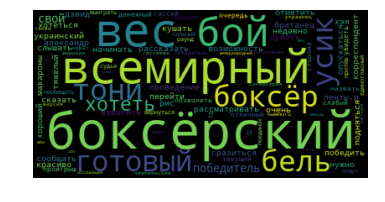

Украинский боксер Александр Усик рассказал, что рассматривает возможность проведения боя с британцем Тони Белью, и готов для этого перейти в другой вес. Об этом сообщает корреспондент "Ленты.ру". "Я слышал, что Тони Белью хотел сразиться с победителем этого боя в тяжелом весе. Он недавно очень красиво победил Дэвида Хэя. От этого, я думаю, можно начинать. Я готов. Если он не хочет опускаться в мой вес, то я поднимусь в его", -- сказал он. При этом боксер отметил, что нужно все взвесить: "Конечно, мне хочется больше кушать риса и макарон, но, может, еще есть хорошие и денежные бои в текущем весе". Гассиев, в свою очередь, назвал свой проигрыш отличным опытом, позволившим увидеть свои слабые стороны. "Мы вернемся намного сильнее", -- пообещал он. 22 июля Усик единогласным решением судей выиграл поединок из 12 раундов против россиянина  Мурата Гассиева. Украинец стал победителем Всемирной боксерской суперсерии, а также обладателем четырех чемпионских поясов по версиям Международной боксер

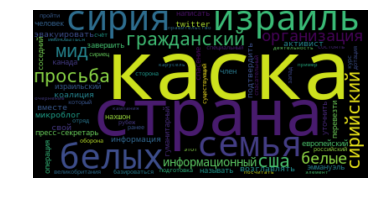

Израиль эвакуировал из Сирии активистов "Белых касок" вместе с их семьями по просьбе коалиции, возглавляемой США. Эту информацию в своем микроблоге в Twitter подтвердил пресс-секретарь израильского МИД Эммануэль Нахшон. "По просьбе США, Канады и европейских стран Израиль завершил гуманитарную операцию по спасению членов сирийской гражданской организации ("Белые каски") и их семей", -- написал он и уточнил, что людей перевезли в соседнюю страну. Так называемые "Белые каски" -- базирующийся в Великобритании спасательный отряд, состоящий из сирийцев, которые прошли курсы специальной подготовки за рубежом, и существующий за счет дотаций со стороны стран Запада. Ранее эта организация именовалась как "Сирийская гражданская оборона". В российском МИД деятельность Белых касок посчитали элементом "информационной кампании по очернению правительства Сирии" и примером "информационной карусели".

proceed? ( [n] to refuse) : 
азар	0.0421052631578947
челси	0.031578947368421054
реал	0.0210526315789473

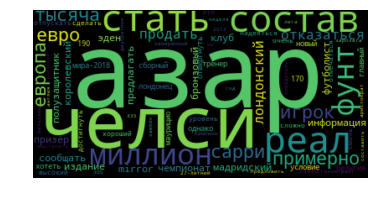

Лондонский "Челси" отказался продать мадридскому "Реалу" полузащитника Эдена Азара. Об этом сообщает Mirror. По информации издания, "Королевский клуб" предлагал за футболиста, ставшего бронзовым призером чемпионата мира-2018 в составе сборной Бельгии, 170 миллионов фунтов (примерно 190 миллионов евро). Однако условия "Реала" были отвергнуты -- новый главный тренер лондонцев Маурицио Сарри не хочет отпускать игрока. "Азар -- один из лучших игроков Европы. Надеюсь, что смогу сделать его лучше, но это будет сложно -- он уже достиг очень высокого уровня", -- заявил Сарри. Отмечается, что "Челси" намерен предложить хавбеку улучшенный контракт. По нему зарплата Азара составит 300 тысяч фунтов (примерно 335 тысяч евро) в неделю. 27-летний Азар выступает за "Челси" с 2012 года. В составе "аристократов" бельгиец стал двукратным чемпионом Англии и победителем Лиги Европы.

proceed? ( [n] to refuse) : n


In [0]:
from collections import defaultdict as dd
from operator import itemgetter
from nltk import word_tokenize
from nltk.corpus import stopwords
from rusenttokenize import ru_sent_tokenize
import string
import pymorphy2
from sklearn.feature_extraction.text import TfidfVectorizer


morph_analyzer = pymorphy2.MorphAnalyzer()
russian_stopwords = stopwords.words('russian')

def preprocess_tokenize(text):
    
    text_preprocessed_tokenized = []
        
    for sentence in ru_sent_tokenize(text):
        
        clean_words = [word.strip(string.punctuation) for word in word_tokenize(text)]
        clean_words = [word for word in clean_words if word]
        clean_words = [word.lower() for word in clean_words if word]
        clean_words = [word for word in clean_words if word not in russian_stopwords]
        
        clean_lemmas = [morph_analyzer.parse(word)[0].normal_form for word in clean_words]
        
        text_preprocessed_tokenized.extend(clean_lemmas)

    return text_preprocessed_tokenized


with open(LENTA_TEXTS_FN) as corpus_f:
    for document in corpus_f:

        text_words_frequencies = dd(int)
        document_tokenized = preprocess_tokenize(document)
        for word in document_tokenized:
            text_words_frequencies[word] += 1 / len(document_tokenized)

        sorted_frequency_table = sorted(text_words_frequencies.items(), 
                                        key=itemgetter(1), reverse=True)    
        
        for word, freq in sorted_frequency_table[:10]:
            print('\t'.join((word, str(freq))))
        
        show_wordcloud_by_freq_dict(text_words_frequencies)
        print(document)
        
        proceed = input("proceed? ( [n] to refuse) : ")
        if proceed.strip().lower() == "n":
            break



## $\textit{Tf-Idf}$

Если частоты считать аккуратно, то списки частотности более-менее передают контраст документов.  
**Но!** если мы возьмём множество документов из какой-то одной и узкой предметной области -- они все будут разделять значительное количество одинаковых штук. Как, например, все тексты содержат много предлогов, но теперь мешаться будут ещё и хоть и осмысленные, но внутри темы повсеместные слова.

$\textit{Tf-Idf}$ &mdash; способ высоко оценить слова, которые одновременно
* показательны в документе
* не вездесущи в корпусе документов


Наивная идея такая: давайте оценка слова будет 
* увеличиваться, если оно частотно в документе и уменьшаться
* уменьшаться, если оно встречается во многих документах

В таком противостоянии победят те слова, которые выделяют документы из кучи им подобных.

---

$$\textit{Tf-Idf}(\mathit{token}, \mathit{document}, \mathit{corpora}) = \mathit{tf}(\mathit{token}, \mathit{document}) \times \mathit{idf}(\mathit{token}, \mathit{corpora}),$$

$\mathit{tf}$ &mdash; частота токена в документе;
$\mathit{idf}$ &mdash; обратно монотонно частоте токена в корпусе

Классическая функция $\mathit{idf}$ $$\mathit{idf}(\mathit{document}, \mathit{corpora}) = \log{\frac{\left| \mathit{corpora} \right|}
{\left| \{ \mathit{document} \in \mathit{corpora}: \mathit{token} \in \mathit{document} \} \right|}}$$ 

### практика

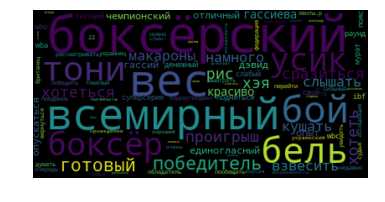

Украинский боксер Александр Усик рассказал, что рассматривает возможность проведения боя с британцем Тони Белью, и готов для этого перейти в другой вес. Об этом сообщает корреспондент "Ленты.ру". "Я слышал, что Тони Белью хотел сразиться с победителем этого боя в тяжелом весе. Он недавно очень красиво победил Дэвида Хэя. От этого, я думаю, можно начинать. Я готов. Если он не хочет опускаться в мой вес, то я поднимусь в его", -- сказал он. При этом боксер отметил, что нужно все взвесить: "Конечно, мне хочется больше кушать риса и макарон, но, может, еще есть хорошие и денежные бои в текущем весе". Гассиев, в свою очередь, назвал свой проигрыш отличным опытом, позволившим увидеть свои слабые стороны. "Мы вернемся намного сильнее", -- пообещал он. 22 июля Усик единогласным решением судей выиграл поединок из 12 раундов против россиянина  Мурата Гассиева. Украинец стал победителем Всемирной боксерской суперсерии, а также обладателем четырех чемпионских поясов по версиям Международной боксер

In [0]:
import sys
from collections import defaultdict as dd
from operator import itemgetter
from nltk import word_tokenize
from nltk.corpus import stopwords
from rusenttokenize import ru_sent_tokenize
import string
import logging
import pymorphy2
from sklearn.feature_extraction.text import TfidfVectorizer


logging.getLogger().setLevel(logging.ERROR)

morph_analyzer = pymorphy2.MorphAnalyzer()
russian_stopwords = stopwords.words('russian')

def preprocess_tokenize(text):
    
    text_preprocessed_tokenized = []
        
    for sentence in ru_sent_tokenize(text):
        
        clean_words = [word.strip(string.punctuation) for word in word_tokenize(text)]
        clean_words = [word for word in clean_words if word]
        clean_words = [word.lower() for word in clean_words if word]
        clean_words = [word for word in clean_words if word not in russian_stopwords]
        
        clean_lemmas = [morph_analyzer.parse(word)[0].normal_form for word in clean_words]
        
        text_preprocessed_tokenized.extend(clean_lemmas)

    return text_preprocessed_tokenized


corpus = []
with open(LENTA_TEXTS_FN) as corpus_f:
    for document in corpus_f:
        corpus.append(document)
        
        if len(corpus) > 1000:
            break



tfidf_vectorizer = TfidfVectorizer(tokenizer=preprocess_tokenize)
tfidf_vectorizer.fit_transform(corpus)
feature_names = tfidf_vectorizer.get_feature_names()


for document in corpus:
    X = tfidf_vectorizer.transform([document])
    
    tfidf_scores = [(feature_names[col], X[0, col]) for col in X.nonzero()[1]]
    freq_list = [(word, freq) for word, freq in sorted(tfidf_scores, 
                                                       key=itemgetter(1), 
                                                       reverse=True)]
    
    show_wordcloud_by_freq_dict(dict(freq_list))
    print(document)
    
    proceed = input("proceed? ( [n] to refuse) : ")
    if proceed.strip().lower() == "n":
        break


## Итог
На коленке достаточно быстро можно реализовать наивное извлечение ключевых слов-фичей из текстов и использовать его дальше в ML или же делать какие-то выводы просто по этим словам.